In [1]:
from utils.mf_exploratory import *

# __<font color='blue'>Bosch Manufacturing</font>__

# __<font color='darkblue'> Part 1: Exploratory Analysis</font>__

------

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data subset is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br>

# 1. Numerical Data Exploration

### A. Dataframe Visualization

As the data is extremely large, it is important to explore the structure of the data to get a feel for what is happening. The numerical data appears to be the most important, so I will start with examining the numerical data.

There are a lot of missing data and null (NaN) values. It is not obvious if this is due to recording errors (which I suspect is not the case), or if it is related to the structuring of the data. I need to continue visualizing the data.

<Figure size 432x288 with 0 Axes>

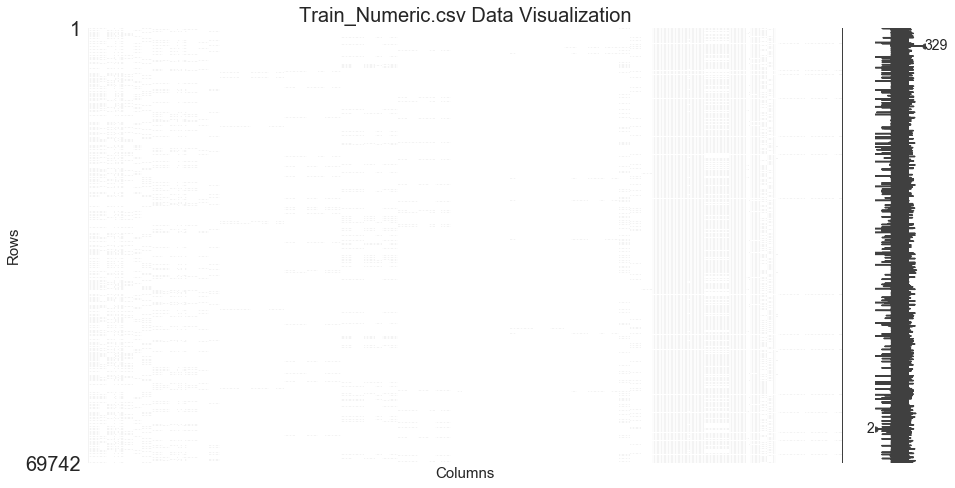

In [2]:
# visualize numerical data with missingno
plt.figure()
msno.matrix(mf_num_data, figsize=(20,6))
plt.title('Train_Numeric.csv Data Visualization',color=(0.239, 0.474, 1), size=20)
plt.ylabel('Rows',size=15)
plt.xlabel('Columns',size=15)
plt.show();

The graph above shows which values are included (purple) and which values are missing (white). The final column on the right side of the graph shows how many values are included in each row. Every row appears to have at most 20-30% of the columns filled in with values. This graph confirms that the data set is very sparse and reaffirms explanations of the data from the Kaggle site and from Hitesh's presentation on the data. 

## B. Features

In [3]:
# show data with pandas
mf_num_data.head(3)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,-0.167,-0.168,0.276,0.33,0.074,0.161,0.052,0.248,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


__Split the column names to look at Line/Station/Features:__

In [4]:
# Create column lists and breakup the strings
columns_set = list(mf_num_data.columns)[1:-1]
breakup_strings = [i.split('_') for i in columns_set]

# store the values in separate containers
line_count = set([i[0] for i in breakup_strings[0:-1]])
station_count = set([i[1] for i in breakup_strings[0:-1]])
feature_count = set([i[2] for i in breakup_strings[0:-1]])

print('Non-Continuous Columns: {}'.format([mf_num_data.columns[0],mf_num_data.columns[-1]]))
print('Unique lines: {}\nUnique Stations: {}\nUnique Feature Measurements: {}'.format(len(line_count),len(station_count),len(feature_count)))

Non-Continuous Columns: ['Id', 'Response']
Unique lines: 4
Unique Stations: 50
Unique Feature Measurements: 967


The ID column lists the product ID for each row. The final Response column is binary (0 or 1) and indicates the ultimate failure or success of the product. There appear to be a lot of different feature measurements located in only 4 lines and 50 stations. This suggests a degree of overlap with the columns and also suggests a directional flow of the data.

## C. Failure Rate Vizualization

__Calculate Failure Rate and Show Visual:__

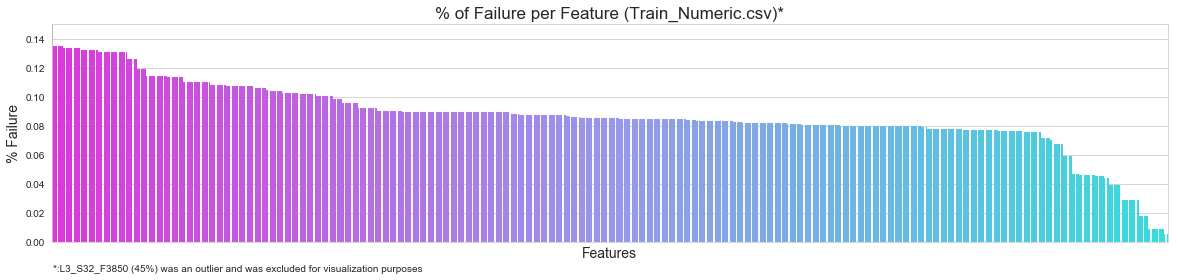

In [5]:
vals = [get_ratio(i) for i in mf_num_data.columns[1:-1]]                 # calculate ratio of failures
sorted_corr = pd.DataFrame(vals).sort_values(by=[1],ascending=False)     # sort values and push to df

plt.figure(figsize=(20,4))
sns.barplot(x=0,y=1,data=sorted_corr,palette="cool_r",linewidth=.1,edgecolor=".8",orient='v')
plt.xticks([])
plt.xlabel('Features',size=14)
plt.ylabel('% Failure',size=14)
plt.ylim(0,.15)
plt.title('Failure % per Feature (Train_Numeric.csv)*',size=17)
plt.text(1,-.02, '*:L3_S32_F3850 (45%) was an outlier and was excluded for visualization purposes')
plt.show()

It helps to visualize each feature by the percentage failure rate. Each column represents a cluster of features. With the exception of L3_S32_F3850, it is clear that most columns have a failure rate between 0.14 and 0.01. Early exploration of the data definitely suggests that their is a distribution of features with very different results.

## D. Graph/Network Data

In [8]:
# Create a network set, convert it to an adjacency matrix, and then save the matrix as a txt file:
create_adjacency_matrix(mf_num_data)

# Calculate the overall failure rate of a line/station:
station_count, station_feature_group, station_name = network_failure_rate(mf_num_data)

# Find list of Starting Stations:
first_stations = set(['_'.join(mf_num_data.iloc[i].dropna().index[1].split('_')[0:2]) for i in range(row_count)])

TypeError: 'NoneType' object is not iterable

__Load and Create NetworkX Graph:__

In [ ]:
# Convert txt file to networkx graph
G=nx.read_adjlist("utils/mf_exploratory_adjaceny.txt", create_using=nx.DiGraph) # A=to_agraph(G)
    
# Map colors to G - this part is messy
station_dict = {}
for i in range(len(station_count)):
    station_dict[station_name[i]] = station_count[i]             # assign count num to stations
min_tick,max_tick = remove_outlier(station_count)  
norm = mpl.colors.Normalize(vmin=min_tick, vmax=max_tick)        # normalize cm gradient range                                
m = cm.ScalarMappable(norm=norm, cmap=cm.cool)                   # rescale cm gradient range to new cmap 
colr_check = [m.to_rgba(station_dict[n]) for n in list(G.nodes)] # converts count torgba

In [ ]:
# Run Visualization
if import_fail: # load premade image if pygraphviz can't load 
    display(Image(filename='network_modeling3.png')) 
    
else: # if pygraphviz does load
    pos = graphviz_layout(G, prog='dot') 
    
    pos_shift = {}
    for k, v in pos.items():
        pos_shift[k] = (v[0], v[1]+3) # offset on the y axis for features
    
    # Begin Visualization
    fig = plt.figure(figsize=(60,50))
    plt.title('Bosch Manufacturing Network',size=60,color='darkblue')
    
    # draw edges
    nx.draw_networkx_edges(G,
                           pos=pos, 
                           alpha=1,
                           width=.7,
                           arrows=False,
                           arrowsize=10,
                           edge_color=range(len(G.edges)),
                           edge_cmap=plt.cm.winter)

    # draw nodes
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=2000, 
                           node_shape = 's',
                           node_color=colr_check,
                           alpha=1)

    # draw labels
    nx.draw_networkx_labels(G,
                            pos=pos,
                            font_color='white')
    
    
    props = dict(boxstyle='round', facecolor='lavender', alpha=0.8)
    
    for k in station_feature_group.keys():
            if k in ['L1_S25']:
                subset= station_feature_group[k][:200]
                subset='\n'.join(subset)
            elif k in ['L1_S24']:
                subset= station_feature_group[k][:140]
                subset='\n'.join(subset)
            else:
                subset='\n'.join(station_feature_group[k])
        
            plt.annotate(subset, xy=pos_shift[k], xytext=(0,30),
                    textcoords='offset points',
                    color='b', size=7,
                    arrowprops=dict(
                        arrowstyle='simple,tail_width=0.3,head_width=0.6,head_length=0.6',
                        facecolor='black',),
                    bbox=props)

    
    # Cleaning visuals
    plt.xticks([]); plt.yticks([]); plt.tight_layout()
    
    # Colorbar
    m.set_array([])                                # needs empty list
    cbaxes = fig.add_axes([.93,.65, 0.005, 0.3]) 
    cbar = plt.colorbar(m,cax=cbaxes)
    cbar.ax.set_title("Station Failure %",size=17)

    plt.savefig('visuals/network_modeling3.png',bbox_inches='tight')
    plt.show()

Experimental Method for Building Network Chain (Unused):

# 2. Timeseries Data

Because this data set represents a manufacturing chain, time is an essential metric. Machine parts could break down during the production, which might ultimately affect a larger batch of the product. The goal of this section is to see if time has any relationship (correlation) with the failure rate of the product.

In [ ]:
# show data
mf_date_data.head(3)

### A. Time Series Visualization

In [ ]:
# Iterate through the columns to get the last time value
last_time =[]
for i in range(len(mf_date_data.iloc[:,1:-1])):
    try:
        lt, sc = final_time(mf_date_data,i)
        last_time.append(lt)
    except:
        last_time.append(0)
mf_date_data['final_time'] = last_time
time_series_plot = mf_date_data[['final_time','Response']] # Append the 'last time' series as a new column

__Final Time Distribution:__

In order to visualize the time data, I decided to capture the final time recorded from each row. By sampling the data via the final time that was recorded, it allows us to visualize the time value as a distribution. Below is a visualization of the time data starting at time 0 and ending near 2000:

In [ ]:
plot_time_series(False)
plt.title('Time series of train_date.csv for final time and response (Regular Count)')
plt.savefig('visuals/timeseries-regular.png')
plt.show()

The sample distributions are by counts. This histogram reinforces my understanding of the data as it shows a marginally smaller subsample of failed products.<br><br>

In [ ]:
plot_time_series(True)
plt.title('Time series of train_date.csv for final time and response (Gaussian Density Estimate)')
plt.savefig('visuals/timeseries-gde.png')
plt.show()

This graph shows the normed distributions of the two samples. In this graph, Failure and Success have relatively different trends. The Success sample group seems to have a smaller cyclical range than the Failure sample group. The peak  for failed products appears to be around 700-800. It would be helpful to know the unit of measurement for the time stamp to consider seasonality (by time of day, month, and/or year), but it is currently not known.

__Method for Getting Distribution Data for creating a Factorization (Unused):__

# C. Categorical Data

Now that the numerical data and the date data have been visualized, the next step is to take a look 

In [ ]:
mf_cat_data.head(3)

Imported categorical data but it doesn't appear to be very useful as some of the information could be gleaned from the numerical data set. Instead of looking at the categorical data, let's look at the numerical data and categorize it via the null value spaces.

# D. Failed Product Exploration

In [ ]:
mf_num_data[mf_num_data['response'] == 0].describe()

In [ ]:
mf_num_data[mf_num_data['Response'] == 1].head()

In [ ]:
features = mf_num_data.columns[1:-1]

In [ ]:
success_mean = [mf_num_data[f][mf_num_data['Response']==0].mean() for f in features]
fail_mean = [mf_num_data[f][mf_num_data['Response']==1].mean() for f in features]
real_mean = [mf_num_data[f].mean() for f in features]

In [ ]:
mean_check = pd.DataFrame(data=[success_mean,fail_mean,real_mean]).T
mean_check['features'] = features
mean_check.columns = ['success_m','fail_m','real_mean','features']
mean_check_reduced = mean_check[0:15]

fig = plt.figure(figsize=(20,10))
sns.barplot(data=mean_check_reduced, x='features', y='fail_m', color='purple',)
sns.barplot(data=mean_check_reduced, x='features', y='success_m', color='lightblue')
plt.title('Comparing Mean Values of Failed vs Successful')
fail = mpatches.Patch(color='purple', label='Fail')
success = mpatches.Patch(color='lightblue', label='Success')
plt.legend(handles=[fail,success])
plt.show()